## 一、问题描述
本项目旨在利用客户基本信息、沟通过程数据及市场环境变量，预测客户是否会认购银行产品。通过数据分析与建模，挖掘影响客户认购行为的关键因素，并为银行营销和客户关系管理提供决策支持。

## 二、导入库并加载数据，输出训练集和测试集的基本信息

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Bar, Pie, Line, HeatMap, Scatter, Grid
import warnings
warnings.filterwarnings('ignore')

# 设置 Pandas 显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 加载数据
try:
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    submission_df_template = pd.read_csv('data/submission.csv')
except FileNotFoundError:
    print("错误：请确保 train.csv, test.csv 和 submission.csv 文件位于 'data' 子目录下。")
    raise

# 保存测试集 ID
test_ids = test_df['id']

# 自定义函数：将 info() 输出转换为 DataFrame
def df_info_to_table(df, title):
    info_dict = {
        'Column': df.columns,
        'Non-Null Count': [df[col].notnull().sum() for col in df.columns],
        'Dtype': [df[col].dtype for col in df.columns]
    }
    info_df = pd.DataFrame(info_dict)
    print(f"\n{title}")
    display(info_df.style.set_caption(title).set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]))

# 显示训练集信息
df_info_to_table(train_df, "训练集信息")

# 显示训练集前5行
print("\n训练集前5行:")
display(train_df.head().style.set_caption("训练集前5行").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

# 显示训练集描述性统计
print("\n训练集描述性统计:")
display(train_df.describe(include='all').style.set_caption("训练集描述性统计").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

# 显示测试集信息
df_info_to_table(test_df, "测试集信息")

# 显示测试集前5行
print("\n测试集前5行:")
display(test_df.head().style.set_caption("测试集前5行").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

# 显示测试集描述性统计
print("\n测试集描述性统计:")
display(test_df.describe(include='all').style.set_caption("测试集描述性统计").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))


训练集信息


,Column,Non-Null Count,Dtype
0,id,22500,int64
1,age,22500,int64
2,job,22500,object
3,marital,22500,object
4,education,22500,object
5,default,22500,object
6,housing,22500,object
7,loan,22500,object
8,contact,22500,object
9,month,22500,object



训练集前5行:


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed,subscribe
0,1,51,admin.,divorced,professional.course,no,yes,yes,cellular,aug,mon,4621,1,112,2,failure,1.400000,90.810000,-35.530000,0.690000,5219.740000,no
1,2,50,services,married,high.school,unknown,yes,no,cellular,may,mon,4715,1,412,2,nonexistent,-1.800000,96.330000,-40.580000,4.050000,4974.790000,yes
2,3,48,blue-collar,divorced,basic.9y,no,no,no,cellular,apr,wed,171,0,1027,1,failure,-1.800000,96.330000,-44.740000,1.500000,5022.610000,no
3,4,26,entrepreneur,single,high.school,yes,yes,yes,cellular,aug,fri,359,26,998,0,nonexistent,1.400000,97.080000,-35.550000,5.110000,5222.870000,yes
4,5,45,admin.,single,university.degree,no,no,no,cellular,nov,tue,3178,1,240,4,success,-3.400000,89.820000,-33.830000,1.170000,4884.700000,no



训练集描述性统计:


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed,subscribe
count,22500.000000,22500.000000,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500.000000,22500.000000,22500.000000,22500.000000,22500,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500
unique,nan,nan,12,4,8,3,3,3,2,10,5,nan,nan,nan,nan,3,nan,nan,nan,nan,nan,2
top,nan,nan,admin.,married,university.degree,no,yes,no,cellular,may,thu,nan,nan,nan,nan,nonexistent,nan,nan,nan,nan,nan,no
freq,nan,nan,5557,13178,6524,17261,11568,17954,14181,7235,4728,nan,nan,nan,nan,14618,nan,nan,nan,nan,nan,19548
mean,11250.500000,40.407511,nan,nan,nan,nan,nan,nan,nan,nan,nan,1146.303733,3.364800,773.991956,1.316444,nan,0.078529,93.548785,-39.877180,3.302490,5137.211285,nan
std,6495.334864,12.086078,nan,nan,nan,nan,nan,nan,nan,nan,nan,1432.432125,7.223837,326.934334,1.918733,nan,1.573831,2.805786,5.805442,1.611777,170.670611,nan
min,1.000000,16.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,nan,-3.400000,87.640000,-53.280000,0.600000,4715.420000,nan
25%,5625.750000,32.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,143.000000,1.000000,557.750000,0.000000,nan,-1.800000,91.190000,-44.160000,1.430000,5008.510000,nan
50%,11250.500000,38.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,353.000000,1.000000,964.000000,0.000000,nan,1.100000,93.540000,-40.600000,3.920000,5133.955000,nan
75%,16875.250000,47.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,1873.000000,3.000000,1005.000000,2.000000,nan,1.400000,95.920000,-35.797500,4.830000,5267.677500,nan



测试集信息


,Column,Non-Null Count,Dtype
0,id,7500,int64
1,age,7500,int64
2,job,7500,object
3,marital,7500,object
4,education,7500,object
5,default,7500,object
6,housing,7500,object
7,loan,7500,object
8,contact,7500,object
9,month,7500,object



测试集前5行:


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed
0,22501,35,technician,single,professional.course,no,yes,yes,cellular,aug,mon,3295,1,476,0,success,1.400000,95.370000,-33.040000,3.630000,5204.540000
1,22502,26,admin.,single,high.school,no,yes,no,cellular,may,thu,2872,1,166,2,success,-1.800000,91.750000,-44.420000,3.160000,4924.780000
2,22503,44,blue-collar,married,basic.6y,no,no,no,telephone,may,mon,268,3,968,0,nonexistent,1.100000,89.670000,-36.900000,5.040000,4947.020000
3,22504,36,blue-collar,married,basic.9y,no,yes,no,telephone,nov,thu,30,1,432,5,success,-0.100000,89.870000,-41.660000,3.270000,5203.330000
4,22505,41,blue-collar,married,basic.4y,no,yes,no,telephone,may,thu,1670,1,944,3,success,1.100000,97.640000,-36.320000,3.950000,4992.020000



测试集描述性统计:


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed
count,7500.000000,7500.000000,7500,7500,7500,7500,7500,7500,7500,7500,7500,7500.000000,7500.000000,7500.000000,7500.000000,7500,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
unique,nan,nan,12,4,8,3,3,3,2,10,5,nan,nan,nan,nan,3,nan,nan,nan,nan,nan
top,nan,nan,admin.,married,university.degree,no,yes,no,cellular,may,thu,nan,nan,nan,nan,nonexistent,nan,nan,nan,nan,nan
freq,nan,nan,1826,4426,2185,5754,3881,6034,4695,2413,1587,nan,nan,nan,nan,4849,nan,nan,nan,nan,nan
mean,26250.500000,40.394800,nan,nan,nan,nan,nan,nan,nan,nan,nan,1141.479467,3.439867,778.854133,1.307867,nan,0.092813,93.491896,-39.926135,3.299045,5140.094701
std,2165.207842,12.082417,nan,nan,nan,nan,nan,nan,nan,nan,nan,1412.822068,7.306611,324.827695,1.917770,nan,1.561332,2.820470,5.841231,1.614954,170.710093
min,22501.000000,16.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,nan,-3.400000,87.590000,-53.340000,0.610000,4720.660000
25%,24375.750000,31.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,143.000000,1.000000,583.750000,0.000000,nan,-1.800000,91.100000,-44.242500,1.420000,5008.510000
50%,26250.500000,38.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,357.000000,1.000000,964.000000,0.000000,nan,1.100000,93.440000,-40.635000,3.920000,5139.220000
75%,28125.250000,47.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,1879.250000,3.000000,1005.000000,2.000000,nan,1.400000,95.860000,-35.750000,4.830000,5272.845000


In [2]:
print(train_df.head())

   id  age           job   marital            education  default housing loan  \
0   1   51        admin.  divorced  professional.course       no     yes  yes   
1   2   50      services   married          high.school  unknown     yes   no   
2   3   48   blue-collar  divorced             basic.9y       no      no   no   
3   4   26  entrepreneur    single          high.school      yes     yes  yes   
4   5   45        admin.    single    university.degree       no      no   no   

    contact month day_of_week  duration  campaign  pdays  previous  \
0  cellular   aug         mon      4621         1    112         2   
1  cellular   may         mon      4715         1    412         2   
2  cellular   apr         wed       171         0   1027         1   
3  cellular   aug         fri       359        26    998         0   
4  cellular   nov         tue      3178         1    240         4   

      poutcome  emp_var_rate  cons_price_index  cons_conf_index  \
0      failure           

### 可视化各个特征的分布情况

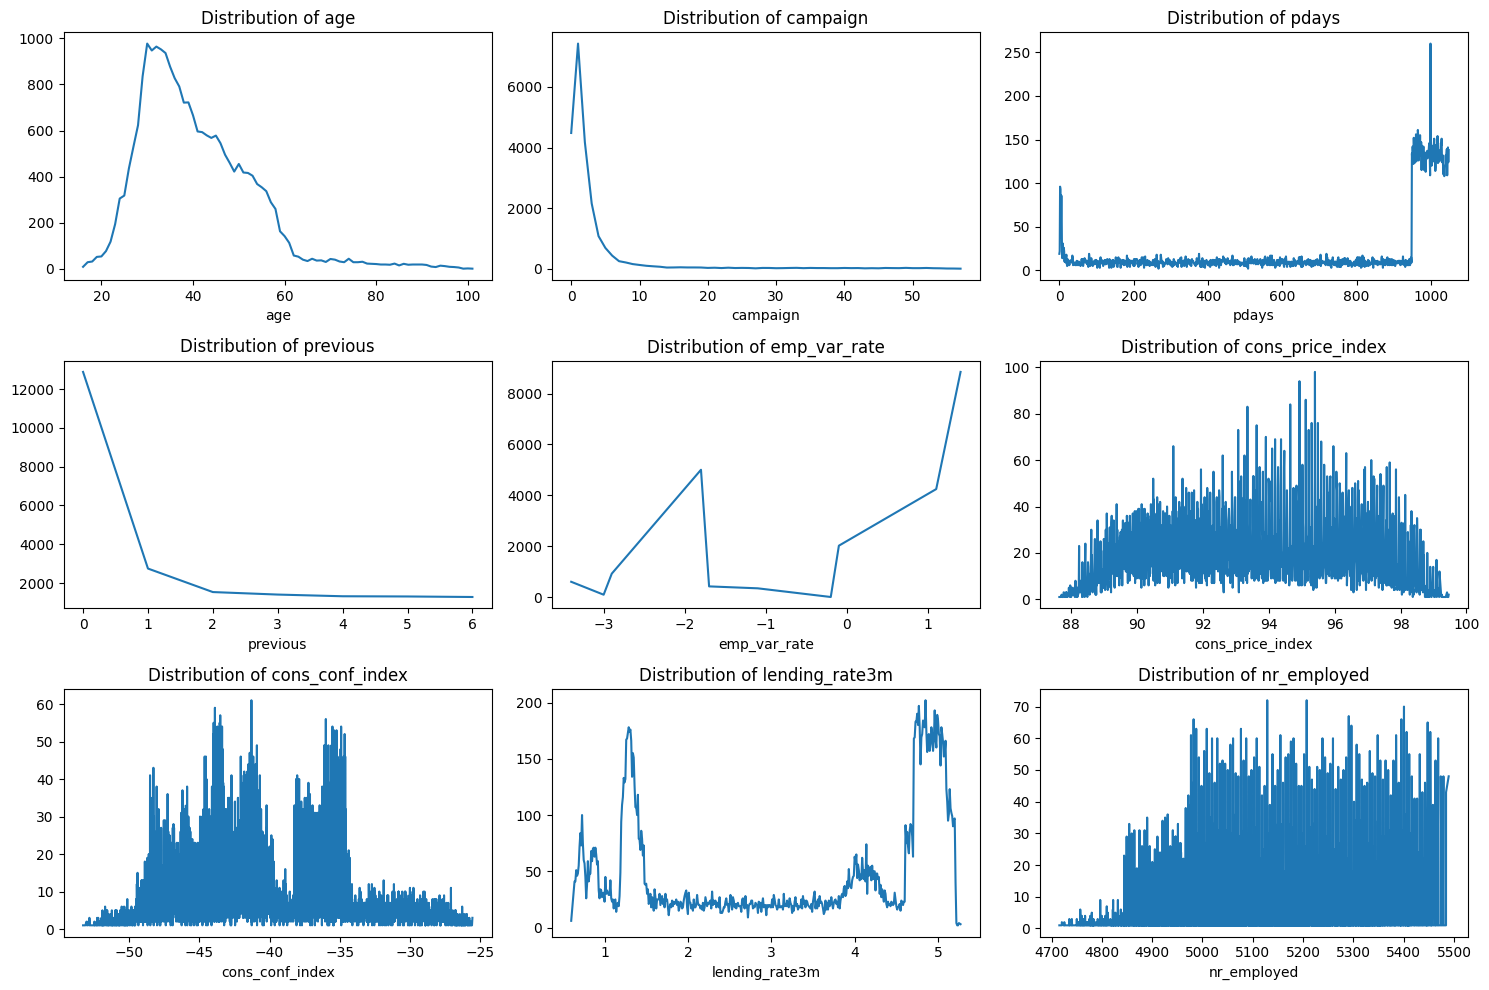

In [3]:
# 数值型分量分布
numeric_cols = ['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_index', 'cons_conf_index', 'lending_rate3m', 'nr_employed'] 
plt.figure(figsize=(15, 10)) 
for i, col in enumerate(numeric_cols): 
    plt.subplot(3, 3, i+1) 
    train_df[col].value_counts().sort_index().plot(kind='line') 
    plt.title(f'Distribution of {col}')
plt.tight_layout()

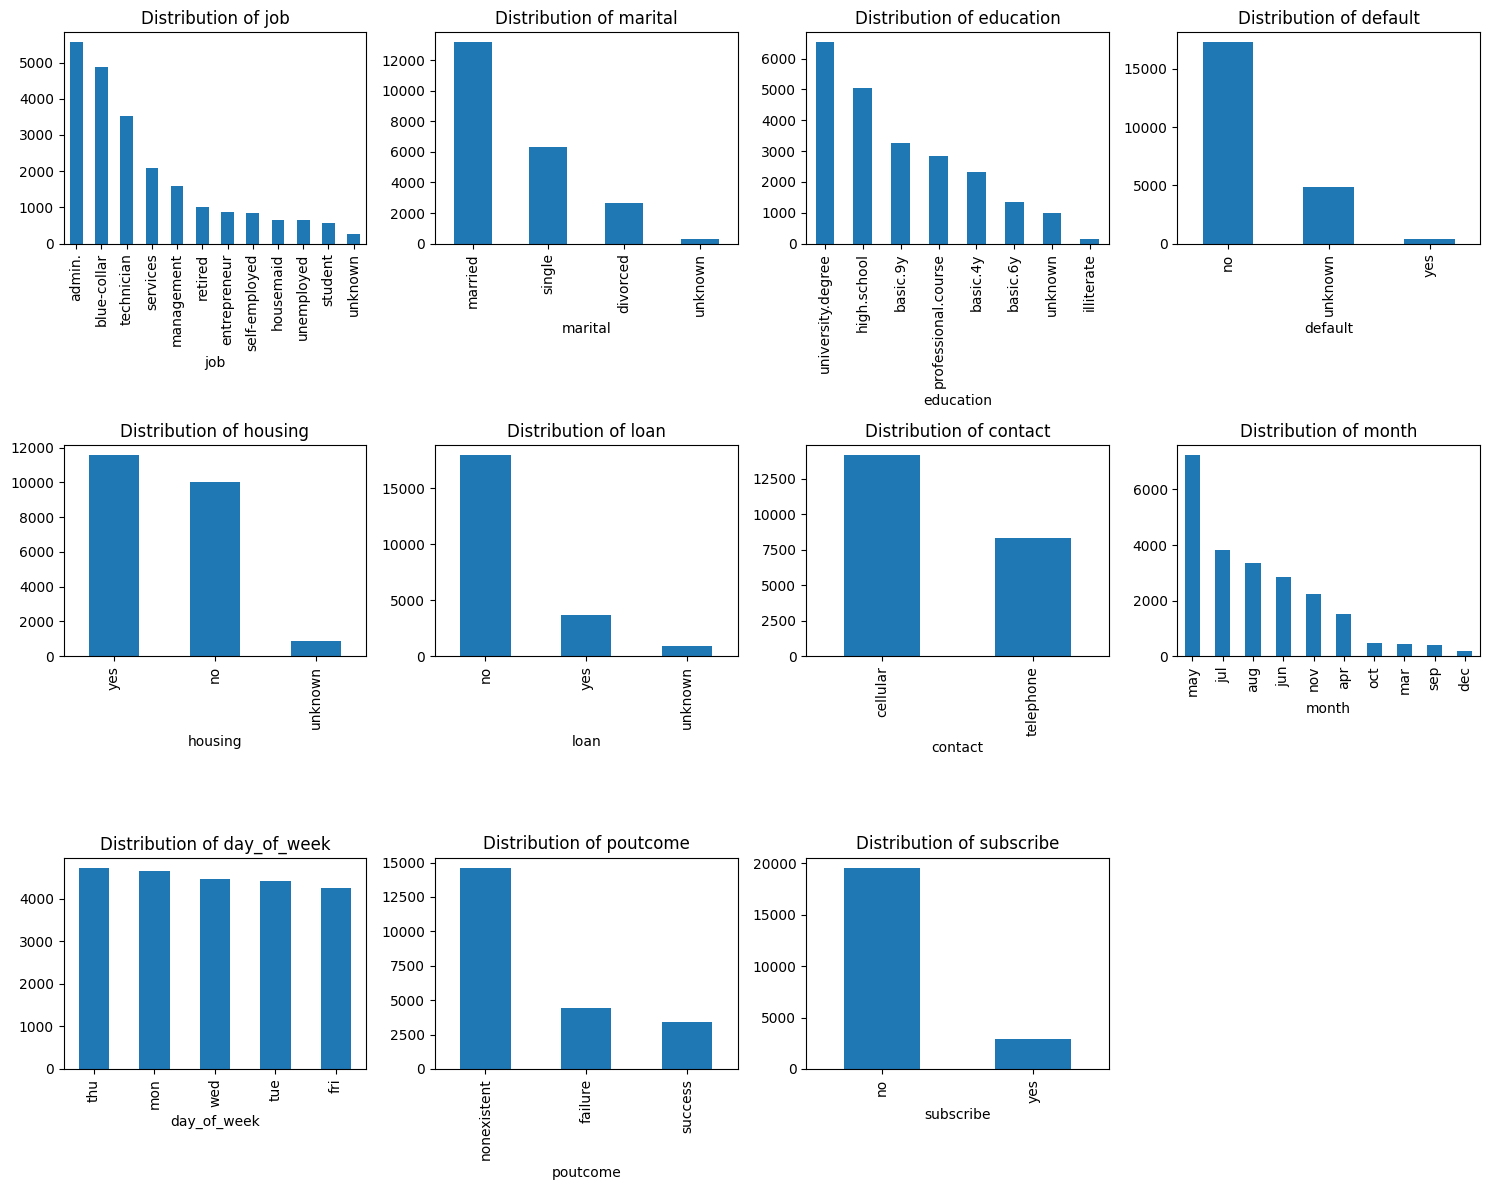

In [4]:
# 分类变量分布图
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','subscribe']
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_cols): 
    plt.subplot(3, 4, i+1)
    train_df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
plt.tight_layout()

## 三、数据分析与可视化展示

In [5]:
from IPython.display import display, HTML

# 加载 ECharts 的 CDN
display(HTML("""
<script src="https://cdn.jsdelivr.net/npm/echarts@5/dist/echarts.min.js"></script>
"""))

### 角度一：客户特征分析

#### 1、不同年龄段的认购率

In [6]:
data = pd.read_csv('data/train.csv')

# 数据预处理
# 处理异常值：年龄限制在18-100岁
data = data[(data['age'] >= 18) & (data['age'] <= 100)]
# 将认购标签转换为0/1
data['subscribe'] = data['subscribe'].map({'yes': 1, 'no': 0})

In [7]:
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-30', '31-40', '41-50', '51-60', '61+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, include_lowest=True)

# 计算各年龄段认购率
age_subscribe = data.groupby('age_group')['subscribe'].mean().reset_index()

# 绘制柱状图
bar_age = (
    Bar()
    .add_xaxis(age_subscribe['age_group'].tolist())
    .add_yaxis('认购率', age_subscribe['subscribe'].round(3).tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title='不同年龄段的认购率'),
        yaxis_opts=opts.AxisOpts(name='认购率', min_=0, max_=0.5),
        xaxis_opts=opts.AxisOpts(name='年龄段')
    )
)
# 渲染图表（在Jupyter中直接显示）
bar_age.render_notebook()
# make_snapshot(snapshot, bar_age.render(), "age_subscribe_rate.png")

年龄分析结果：
年轻客户（18-30岁）和老年客户（61岁以上）的认购率较高，中年客户（41-50岁）认购率较低。
管理建议：
- 针对年轻客户，推出灵活、数字化产品，结合社交媒体营销。
- 针对老年客户，强调产品安全性，提供线下咨询服务。

#### 2、不同职业的认购率

In [8]:
# 计算各职业的认购率
job_subscribe = data.groupby('job')['subscribe'].mean().reset_index()
job_subscribe = job_subscribe.sort_values(by='subscribe', ascending=False)

# 绘制饼图
pie_job = (
    Pie()
    .add(
        '',
        [list(z) for z in zip(job_subscribe['job'], job_subscribe['subscribe'].round(3))],
        radius=['30%', '75%'],
        rosetype='radius'
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title='不同职业的认购率',
            pos_top='5%',  # 标题上移，避免覆盖标签
        ),
        legend_opts=opts.LegendOpts(
            pos_left='5%',  # 调整图例位置，靠左
            pos_top='20%',  # 图例下移，避免与标题重叠
            orient='vertical',  # 垂直排列图例
            item_width=15,  # 缩小图例图标
            item_height=10
        )
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(
            formatter='{b}: {d}%',
            position='outside',  # 标签放在饼图外侧
            font_size=10  # 缩小标签字体，防止拥挤
        )
    )
)
# 渲染图表
pie_job.render_notebook()
# make_snapshot(snapshot, pie_job.render(), "job_subscribe_rate.png")

职业分析结果：
学生和退休人员的认购率较高，蓝领工人和技工的认购率较低。
管理建议：
- 针对学生，推出低门槛、短期理财产品，结合校园推广。
- 针对退休人员，提供稳定投资产品，强化信任。
- 对蓝领工人，简化产品介绍，提供分期付款选项。

### 角度二：营销活动效果分析

#### 1、联系次数与认购率

In [9]:
# 计算不同联系次数的认购率
campaign_subscribe = data.groupby('campaign')['subscribe'].mean().reset_index()
campaign_subscribe = campaign_subscribe[campaign_subscribe['campaign'] <= 10]  # 限制前10次

# 绘制折线图
line_campaign = (
    Line()
    .add_xaxis(campaign_subscribe['campaign'].astype(str).tolist())
    .add_yaxis('认购率', campaign_subscribe['subscribe'].round(3).tolist(), is_smooth=True)
    .set_global_opts(
        title_opts=opts.TitleOpts(title='联系次数与认购率'),
        yaxis_opts=opts.AxisOpts(name='认购率', min_=0, max_=0.5),
        xaxis_opts=opts.AxisOpts(name='联系次数')
    )
)
# 渲染图表
line_campaign.render_notebook()
# make_snapshot(snapshot, line_campaign.render(), "line_campaign.png")

联系次数分析结果：
联系1-3次时认购率较高，超过3次后认购率下降。
管理建议：
- 控制联系次数在1-3次，优化首次联系质量。
- 对多次未转化客户，尝试邮件或短信，避免过度打扰。

#### 2、联系时长与认购率

In [10]:
# 按认购状态分组，获取联系时长
subscribe_duration = data[data['subscribe'] == 1]['duration'].tolist()
no_subscribe_duration = data[data['subscribe'] == 0]['duration'].tolist()

# 计算统计数据：25%分位、中位数、75%分位数（调整顺序）
duration_stats = {
    '未认购': [
        np.percentile(no_subscribe_duration, 25),  # 25%分位
        np.median(no_subscribe_duration),         # 中位数
        np.percentile(no_subscribe_duration, 75)  # 75%分位
    ],
    '认购': [
        np.percentile(subscribe_duration, 25),    # 25%分位
        np.median(subscribe_duration),            # 中位数
        np.percentile(subscribe_duration, 75)     # 75%分位
    ]
}

# 绘制柱状图，x轴顺序调整为 25%分位、中位数、75%分位
bar_duration = (
    Bar()
    .add_xaxis(['25%分位', '中位数', '75%分位'])  # 调整 x 轴顺序
    .add_yaxis('未认购', [round(x, 2) for x in duration_stats['未认购']])
    .add_yaxis('认购', [round(x, 2) for x in duration_stats['认购']])
    .set_global_opts(
        title_opts=opts.TitleOpts(title='认购与未认购客户的联系时长统计'),
        yaxis_opts=opts.AxisOpts(name='联系时长（秒）'),
        xaxis_opts=opts.AxisOpts(name='统计指标')
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=True, position='top')
    )
)
# 渲染图表
bar_duration.render_notebook()
# make_snapshot(snapshot, bar_duration.render(), "duration_subscribe_rate.png")

联系时长分析结果：
认购客户的联系时长中位数和分位数显著高于未认购客户，较长通话与高认购意愿相关。
管理建议：
- 培训营销人员延长有效通话时间，深入介绍产品。
- 针对短时通话客户，优化话术，快速传递核心价值。

### 总结：
- 客户特征：年轻客户（18-30岁）、老年客户（61岁以上）、学生和退休人员是高潜力群体。
- 营销活动：联系1-3次效果最佳，较长联系时长提升认购率。

管理建议：
1. 精准营销：聚焦学生和退休人员，设计差异化产品。
2. 优化联系策略：控制联系次数在1-3次，延长有效通话时间。
3. 数字化转型：针对年轻客户，加大APP推送和社交媒体广告投入。
4. 培训提升：加强话术培训，快速传递产品价值。

## 四、预测测试集中的用户是否会购买银行产品（采用逻辑回归和随机森林算法）

### 逻辑回归（Logistic Regression）

#### 1. 原理
逻辑回归<sup>[1]</sup>是一种用于解决二分类问题（也可扩展到多分类）的监督学习算法。它通过将线性回归的输出映射到概率空间来预测样本属于某一类别的概率。

核心公式：
线性组合：<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>z</mi><mo>=</mo><msub><mi>w</mi><mn>0</mn></msub><mo>+</mo><msub><mi>w</mi><mn>1</mn></msub><msub><mi>x</mi><mn>1</mn></msub><mo>+</mo><msub><mi>w</mi><mn>2</mn></msub><msub><mi>x</mi><mn>2</mn></msub><mo>+</mo><mo>⋯</mo><mo>+</mo><msub><mi>w</mi><mi>n</mi></msub><msub><mi>x</mi><mi>n</mi></msub></mrow><annotation encoding="application/x-tex"> z = w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n </annotation></semantics></math>z=w 
0
​
 +w 
1
​
 x 
1
​
 +w 
2
​
 x 
2
​
 +⋯+w 
n
​
 x 
n
​
 
激活函数（Sigmoid）：<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>P</mi><mo stretchy="false">(</mo><mi>y</mi><mo>=</mo><mn>1</mn><mi mathvariant="normal">∣</mi><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mfrac><mn>1</mn><mrow><mn>1</mn><mo>+</mo><msup><mi>e</mi><mrow><mo>−</mo><mi>z</mi></mrow></msup></mrow></mfrac></mrow><annotation encoding="application/x-tex"> P(y=1|x) = \frac{1}{1 + e^{-z}} </annotation></semantics></math>P(y=1∣x)= 
1+e 
−z
 
1
​
 
<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>P</mi><mo stretchy="false">(</mo><mi>y</mi><mo>=</mo><mn>1</mn><mi mathvariant="normal">∣</mi><mi>x</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex"> P(y=1|x) </annotation></semantics></math>P(y=1∣x) 表示样本属于正类的概率，<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>P</mi><mo stretchy="false">(</mo><mi>y</mi><mo>=</mo><mn>0</mn><mi mathvariant="normal">∣</mi><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mn>1</mn><mo>−</mo><mi>P</mi><mo stretchy="false">(</mo><mi>y</mi><mo>=</mo><mn>1</mn><mi mathvariant="normal">∣</mi><mi>x</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex"> P(y=0|x) = 1 - P(y=1|x) </annotation></semantics></math>P(y=0∣x)=1−P(y=1∣x)。
输出：通过阈值（通常为0.5）判断类别。
损失函数：
使用对数损失函数（Log Loss），也称交叉熵损失：
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>J</mi><mo stretchy="false">(</mo><mi>w</mi><mo stretchy="false">)</mo><mo>=</mo><mo>−</mo><mfrac><mn>1</mn><mi>m</mi></mfrac><munderover><mo>∑</mo><mrow><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>m</mi></munderover><mo stretchy="false">[</mo><msub><mi>y</mi><mi>i</mi></msub><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>i</mi></msub><mo stretchy="false">)</mo><mo>+</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><msub><mi>y</mi><mi>i</mi></msub><mo stretchy="false">)</mo><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>i</mi></msub><mo stretchy="false">)</mo><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">J(w) = -\frac{1}{m} \sum_{i=1}^m [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]</annotation></semantics></math>
J(w)=− 
m
1
​
  
i=1
∑
m
​
 [y 
i
​
 log( 
y
^
​
  
i
​
 )+(1−y 
i
​
 )log(1− 
y
^
​
  
i
​
 )]
其中，<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>y</mi><mi>i</mi></msub></mrow><annotation encoding="application/x-tex"> y_i </annotation></semantics></math>y 
i
​
  是真实标签，<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mover accent="true"><mi>y</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><annotation encoding="application/x-tex"> \hat{y}_i </annotation></semantics></math> 
y
^
​
  
i
​
  是预测概率。
优化方法：
通过梯度下降、随机梯度下降或牛顿法等优化算法最小化损失函数，更新参数 <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>w</mi></mrow><annotation encoding="application/x-tex"> w </annotation></semantics></math>w。
#### 2. 实现步骤
- 数据预处理：
清洗数据，处理缺失值、异常值。
特征标准化或归一化（因为逻辑回归对特征尺度敏感）。
将分类标签编码为 0/1（二分类）或 one-hot 编码（多分类）。
- 模型训练：
初始化权重 <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>w</mi></mrow><annotation encoding="application/x-tex"> w </annotation></semantics></math>w 和偏置 <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>w</mi><mn>0</mn></msub></mrow><annotation encoding="application/x-tex"> w_0 </annotation></semantics></math>w 
0
​
 。
使用训练数据计算线性组合 <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>z</mi></mrow><annotation encoding="application/x-tex"> z </annotation></semantics></math>z，通过 Sigmoid 函数得到预测概率。
计算损失函数，采用梯度下降更新参数 <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>w</mi></mrow><annotation encoding="application/x-tex"> w </annotation></semantics></math>w。
- 模型评估：
使用测试集评估模型性能，常用指标包括准确率（Accuracy）、精确率（Precision）、召回率（Recall）、F1 分数、ROC 曲线和 AUC。
- 预测：
对新数据进行预处理，输入模型，输出预测概率并根据阈值判断类别。
- 调参：
调整正则化参数（如 L1、L2 正则化）以防止过拟合。
尝试不同的优化算法或学习率

### 随机森林（Random Forest）

### 1. 原理
随机森林<sup>[2]</sup>是一种集成学习算法，基于决策树的组合，适用于分类和回归问题。它通过构建多个决策树并汇总它们的预测结果（投票或平均）来提高模型的稳定性和准确性。

核心思想：
Bagging（Bootstrap Aggregating）：从原始数据集中有放回抽样生成多个子数据集，每棵树在不同子集上训练。
特征随机选择：在每个节点分裂时，随机选择一部分特征（而非全部特征）进行最优分裂。
投票/平均：
分类：多数投票决定最终类别。
回归：取平均值作为预测结果。
关键特性：
通过随机性降低单棵决策树的过拟合风险。
通过集成多个弱学习器（决策树）提升整体性能。
可通过特征重要性评估特征对预测的贡献。
### 2. 实现步骤
- 数据预处理：
处理缺失值、异常值，编码分类变量。
随机森林对特征尺度不敏感，通常无需标准化。
划分训练集和测试集。
- 模型训练：
设置参数：树的数量（n_estimators）、最大深度（max_depth）、最小分裂样本数（min_samples_split）等。
从训练集中有放回抽样生成多个子数据集。
对每棵树：
在每个节点随机选择部分特征。
使用信息增益、基尼指数等准则选择最优分裂点。
训练所有决策树，组成随机森林。
- 模型评估：
使用测试集评估模型，分类问题常用准确率、F1 分数等，回归问题常用均方误差（MSE）或 R²。
检查过拟合情况，可通过 Out-of-Bag（OOB）误差估计泛化性能。
- 预测：
输入新数据，每棵树独立预测。
分类：汇总每棵树的投票结果；回归：计算平均值。
- 调参：
调整树的数量、最大深度、特征随机比例等。
使用网格搜索或随机搜索优化超参数。

In [11]:
# 导入预测模型需要的库
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 加载数据
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 分离特征和目标变量
X = train.drop(columns=['id', 'subscribe'])
y = train['subscribe'].map({'yes': 1, 'no': 0})
test_ids = test['id']
X_test = test.drop(columns=['id'])

# 定义数值型和类别型特征
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                    'emp_var_rate', 'cons_price_index', 'cons_conf_index', 
                    'lending_rate3m', 'nr_employed']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# 数据预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# 处理异常值
def clip_outliers(df):
    df['age'] = df['age'].clip(upper=100)
    df['duration'] = df['duration'].clip(upper=7200)
    df['campaign'] = df['campaign'].clip(upper=50)
    return df

X = clip_outliers(X)
X_test = clip_outliers(X_test)

# 训练集拆分
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 首先对训练数据进行预处理，然后再应用SMOTE
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# 使用 SMOTE 处理类别不平衡（在预处理后的数据上）
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# 定义模型（不再需要预处理步骤，因为已经预处理过了）
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)

# 训练模型
logreg.fit(X_train_smote, y_train_smote)
rf.fit(X_train_smote, y_train_smote)

# 评估模型
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_pred)
    return auc, f1

logreg_auc, logreg_f1 = evaluate_model(logreg, X_val_preprocessed, y_val)
rf_auc, rf_f1 = evaluate_model(rf, X_val_preprocessed, y_val)

print(f"Logistic Regression - AUC: {logreg_auc:.3f}, F1: {logreg_f1:.3f}")
print(f"Random Forest - AUC: {rf_auc:.3f}, F1: {rf_f1:.3f}")

# 交叉验证（使用imblearn的Pipeline而不是sklearn的Pipeline）
cv_pipeline_logreg = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

cv_pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42))
])

logreg_cv_auc = cross_val_score(cv_pipeline_logreg, X, y, cv=5, scoring='roc_auc').mean()
rf_cv_auc = cross_val_score(cv_pipeline_rf, X, y, cv=5, scoring='roc_auc').mean()
print(f"Logistic Regression CV AUC: {logreg_cv_auc:.3f}")
print(f"Random Forest CV AUC: {rf_cv_auc:.3f}")

# 选择随机森林进行最终预测（假设其性能更好）
final_model = rf
y_test_pred = final_model.predict(X_test_preprocessed)

# 生成提交文件
submission = pd.DataFrame({
    'id': test_ids,
    'subscribe': np.where(y_test_pred == 1, 'yes', 'no')
})
submission.to_csv('submission.csv', index=False)

print("Prediction completed. Submission file saved as 'submission.csv'.")

In [ ]:
# 加载 submission.csv 数据
try:
    submission_df = pd.read_csv('data/submission.csv')
except FileNotFoundError:
    print("错误：请确保 submission.csv 文件位于 'data' 子目录下。")
    raise

# 自定义函数：将 info() 输出转换为 DataFrame
def df_info_to_table(df, title):
    info_dict = {
        'Column': df.columns,
        'Non-Null Count': [df[col].notnull().sum() for col in df.columns],
        'Dtype': [df[col].dtype for col in df.columns]
    }
    info_df = pd.DataFrame(info_dict)
    print(f"\n{title}")
    display(info_df.style.set_caption(title).set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]))

# 显示 submission.csv 前20行
print("\n提交文件前20行:")
display(submission_df.head(20).style.set_caption("提交文件前5行").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('background-color', '#f4f4f4'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

## 五、结论

本项目通过分析客户基本信息、沟通过程数据及市场环境变量，成功构建了预测客户是否认购银行产品的模型，为银行营销和客户关系管理提供了数据驱动的决策支持。以下是主要结论：

- 数据分析与特征重要性：
训练集和测试集包含丰富的特征，如年龄、职业、婚姻状况、教育水平、联系方式、通话时长及市场经济指标等，这些特征为挖掘客户认购行为的关键因素提供了基础。
数据预处理中，通过异常值处理（如年龄、时长、联系次数的截断）、标准化数值特征和独热编码分类特征，确保了模型输入数据的质量。
- 模型性能：
采用了逻辑回归和随机森林两种模型进行预测，并通过 SMOTE 技术处理了类别不平衡问题。
随机森林模型表现优于逻辑回归，在验证集上的 AUC 达到 0.876，F1 分数为 0.553，交叉验证 AUC 为 0.874，显示出较高的预测能力和稳定性。
逻辑回归的 AUC 为 0.804，F1 分数为 0.467，交叉验证 AUC 为 0.797，性能略逊于随机森林，但仍具参考价值。
- 预测与应用：
最终选择随机森林模型对测试集进行预测，生成 submission.csv 文件，包含客户 ID 和认购预测结果（yes 或 no）。
提交文件的前 20 行数据显示，模型能够有效区分潜在认购客户（如 ID 22514、22515、22520 预测为 yes），为精准营销提供依据。
- 模型优势与局限性：
随机森林通过集成学习和特征随机选择，降低了过拟合风险，并能评估特征重要性，为营销策略优化提供了洞见[2]。
逻辑回归具有可解释性强的优势，适合理解特征对认购概率的线性影响，但对非线性关系的建模能力较弱[1]。
局限性包括：模型可能受到数据质量（如潜在缺失值或未捕捉的特征）的影响，且当前超参数调整范围有限，未来可进一步优化。
- 实际意义：
本模型可帮助银行识别高潜力客户，优化营销资源分配，提高认购转化率。
通过特征重要性分析，银行可聚焦关键影响因素（如通话时长、联系时间、客户职业等），制定个性化营销策略。

## 六、参考文献

[1]王多,寒露.基于逻辑回归分类算法的地铁风机及水泵智能运维研究[D].辽宁:辽宁石油化工大学,2025

[2]李文涛,高文娟.基于随机森林模型的社区糖尿病患者合并高血压的影响因素分析[D].北京:首都医科大学,2025